# **※ 하이블루밍 포토그래픽 모자이크 ※**

![결과 샘플](https://drive.google.com/uc?export=view&id=1KdeEm2AU6W684ObARKo1PF6sE8aslM2M)
---
- 스크린샷 수: 6269
- 스크린샷 수집 기간: ~2026.01.03
- 소요시간 (샘플 이미지 기준) (세로로 길어질수록 시간 증가)
| 가로_타일_수 | 소요시간 | 스크린샷 중복 개수 |
| --- | --- | --- |
| 110 | 17 분 | 1 |
| 78 | 6 분 | 0 |

- 샘플 이미지: [순연애의 잉곳](https://www.youtube.com/watch?v=POhyXqOgLBk&list=RDPOhyXqOgLBk&start_radio=1)
- 스크린샷 출처: [하네다시보기](https://www.youtube.com/@하네다시보기) / [오프하루](https://www.youtube.com/@off_haru) / [김뒷태의이중생활](https://www.youtube.com/@김뒷태의이중생활) / [소리다시보기](https://www.youtube.com/@소리다시보기)
---
# ※※ 하이블루밍 ※※
- 하네: [유튜브](https://www.youtube.com/watch?v=NTpZsN7qviE) / [CHZZK](https://chzzk.naver.com/live/7b9c6553913c755812ef2cd9fbe1dc5c) / [X](https://x.com/otw_hane/with_replies)
- 하루: [유튜브](https://www.youtube.com/@otw_onharu) / [유튜브_뮤직채널](https://www.youtube.com/@otw_haru) / [CHZZK](https://chzzk.naver.com/live/0f61ae00c2aef2b789dc009e51cbcc5a) / [X](https://x.com/otw_haru)
- 김아테: [유튜브](https://www.youtube.com/@otw_Ate) / [CHZZK](https://chzzk.naver.com/live/f42e97f59c3177b8686dccfbf90792dd) / [X](https://x.com/otw_ate)
- 오토노 소리: [유튜브](https://www.youtube.com/@otw_sori) / [CHZZK](https://chzzk.naver.com/live/2e5c0e7ce8321194127e4d79c83c36d4) / [X](https://x.com/otw_sori)

<br>
   
- [웹툰 나노마신 x 김아테, 온하루] [해방 MV](https://www.youtube.com/watch?v=GgTKuSbCZq0)
- [웹툰 절대검감 x 김아테, 온하루] [구름에 지는 달 MV](https://www.youtube.com/watch?v=mSBxWKhCFLM&list=PLlU0BLctZTmCd9T1tROeDugFlxPa15klN&index=3)
- [웹툰 절대검감 x 오토노 소리, 하네] [너라서 그래 MV](https://www.youtube.com/watch?v=We6toM60--c)


In [ ]:
# @markdown ###[Option]

샘플_이미지_사용 = "True" # @param ["True","False"]
가로_타일_수 = "110" #@param [100, 90, 80, 78, 70, 60] {allow-input: true}
보정_비율 = "0.15" #@param [0, 0.1, 0.15, 0.2, 0.25, 0.3] {allow-input: true}
JGP_로_저장 = "False" #@param ["True","False"] 

try:
    from google.colab import files, output
    import zipfile
    import os
    IS_COLAB = True

    upload = lambda : list(files.upload())[0]
    def download(folder, output="output"):
      shutil.make_archive(output, 'zip', folder)
      files.download(f"{output}.zip")

except:
    IS_COLAB = False
    upload = lambda : input("Target img path: ")
    download = lambda x: None

SAMPLE_NUMBER = 1
PATH_UPLOADED_IMG = None if (샘플_이미지_사용 == "True") else upload()

# Setting
---

Import

In [2]:
if (IS_COLAB):
    ! pip install lapx

In [ ]:
import torch
import numpy as np
import cv2
import os
import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
import h5py
from tqdm import tqdm
import shutil
from PIL import Image
from torchvision import transforms
import math
import lap
import sys
import gc
import time
st = time.time()

Image.MAX_IMAGE_PIXELS = None

if (IS_COLAB):
    if (not os.path.isfile("sample.png")):
        if (SAMPLE_NUMBER == 1):
          ! gdown --id 19o_JpGbMsnxTP-9Gw2eQQRrPiPRu766T --output sample.png
        else :
          ! gdown --id 1jgPf9zZ7sang0Uyhuht6GuCNQkws7BgN --output sample.png
    if (not os.path.isfile("dataset.h5")):
        ! gdown --id 18evVK2f36obpvE82u5rZoDDWLC7ysp-H --output dataset.h5
    if (not os.path.isfile("dataset.json")):
        ! gdown --id 1dtBMJXYchCRTZvT4hFu6penm0BwT5DPF --output dataset.json
    if (not os.path.isfile("web-reference.zip")):
        ! gdown --id 1GQqtTqC3V-Pyn5WCbU_Kk4yGQkqebNxT --output web-reference.zip
        shutil.unpack_archive("web-reference.zip", "", "zip")

    ROOT = ""

else:
    ROOT = "dataset"

# TORCH
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# option
USE_SAMPLE_INPUT = (샘플_이미지_사용 == "True")
BLENDING_RATE = min(max(0, float(보정_비율)), 1)
SAVE_AS_JPG = (JGP_로_저장 == "True")

# web viewer
WEB_TILE_SIZE = 256

# source path
PATH_H5 = os.path.join(ROOT, "dataset.h5")
PATH_JSON = os.path.join(ROOT, "dataset.json")
PATH_TARGET_IMG = os.path.join(ROOT, "sample.png") if (USE_SAMPLE_INPUT) else PATH_UPLOADED_IMG
OUTPUT_PATH = "hi-blueming-photographic-moaisc"
WEB_REF_PATH = "web-reference"

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# configure
with open(PATH_JSON, "r", encoding="utf-8") as f:
    config = json.load(f)

SOURCE_N, SOURCE_SHAPE_HEIGHT, SOURCE_SHAPE_WIDTH, _ = tuple(config["origin_shape"])
_, EMBEDDING_LENGTH = tuple(config["embedding_shape"])
EMBEDDING_N = int(EMBEDDING_LENGTH/3)
EMBEDDING_ROW, EMBEDDING_COL = tuple(config["embedding_size"])
SOURCE_SHAPE = (SOURCE_SHAPE_WIDTH, SOURCE_SHAPE_HEIGHT)

# tile size
img = cv2.imread(PATH_TARGET_IMG)
h, w, _ = img.shape

ROW_TILE_N = int(가로_타일_수)
COL_TILE_N = int(h/(w/ROW_TILE_N*9/16))

temp = ((w // ROW_TILE_N) + 1)
target_h, target_w = int(temp*9/16)*COL_TILE_N, temp*ROW_TILE_N
COPY_CNT = int((ROW_TILE_N*COL_TILE_N)//SOURCE_N)+1

target_embedding_map_shape = (EMBEDDING_ROW * ROW_TILE_N, EMBEDDING_COL * COL_TILE_N)

if (IS_COLAB):
    output.clear()
print(f"""
IS_COLAB: {IS_COLAB}
USE_SAMPLE_INPUT: {USE_SAMPLE_INPUT}
EMBEDDING_ROW: {EMBEDDING_ROW}
EMBEDDING_COL: {EMBEDDING_COL}
EMBEDDING_N: {EMBEDDING_N}
DEVICE: {DEVICE}
BLENDING_RATE: {BLENDING_RATE}
USE_SAMPLE_INPUT: {USE_SAMPLE_INPUT}
ROW_TILE_N: {ROW_TILE_N}
COL_TILE_N: {COL_TILE_N}
COPY_CNT: {COPY_CNT}
""")


IS_COLAB: False
USE_SAMPLE_INPUT: True
EMBEDDING_ROW: 16
EMBEDDING_COL: 9
EMBEDDING_N: 144
DEVICE: cuda
BLENDING_RATE: 0.15
USE_SAMPLE_INPUT: True
ROW_TILE_N: 110
COL_TILE_N: 109
COPY_CNT: 2



functions

In [4]:
def resize_crop(source:np.array, size:tuple, interpolation=cv2.INTER_LANCZOS4):
    h, w = size
    rate = w/h
    s_h, s_w = source.shape[:2]
    s_rate = s_w/s_h

    if (rate < s_rate):
        crop_h, crop_w = s_h, int(s_h*rate)
        offset_h, offset_w = 0, (s_w-crop_w)//2
    else:
        crop_h, crop_w = int(s_w/rate), s_w
        offset_h, offset_w = (s_h-crop_h)//2, 0


    cropped = source[offset_h:offset_h+crop_h, offset_w:offset_w+crop_w]
    resized = cv2.resize(cropped, size[::-1], interpolation=interpolation)

    return resized

In [5]:
def blend(A, B, rate):
  mixed_ab = A[:, :, 1:] * (1 - rate) + B[:, :, 2:] * rate

  A[:, :, 1:] = mixed_ab
  return A

  #return (1 - rate) * A + rate * B

# Main
---

Load target image

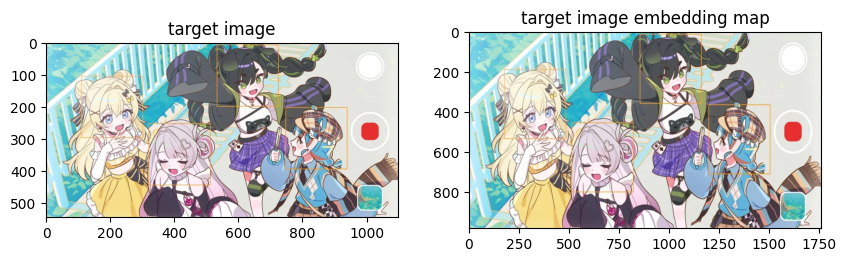

In [6]:
img_resized = resize_crop(img, (target_h, target_w))
img_LAB = cv2.cvtColor(img_resized, cv2.COLOR_BGR2Lab)
#img_LAB_blur = cv2.GaussianBlur(img_LAB, (3, 3), 0)
img_RGB = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
target_embedding_map = cv2.resize(img_LAB, target_embedding_map_shape, interpolation=cv2.INTER_AREA)

plt.figure(figsize=(10, 30))
plt.subplot(1, 2, 1); plt.imshow(img_RGB); plt.title("target image")
plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(target_embedding_map, cv2.COLOR_Lab2RGB)); plt.title("target image embedding map")
plt.show()

load data

In [7]:
tiles = None
tiles_embedding = None
labels = None
targets_embedding = []

# from dataset
with h5py.File(PATH_H5, 'r') as f:
    tiles_embedding = torch.from_numpy(f["embedding"][:])

labels = config["label"]

# embedding from target
for i in range(ROW_TILE_N):
    for j in range(COL_TILE_N):
        r, c = EMBEDDING_ROW * i, EMBEDDING_COL * j
        e_map = target_embedding_map[c:c+EMBEDDING_COL, r:r+EMBEDDING_ROW, :]
        e_vector = e_map.flatten()
        targets_embedding.append(e_vector)

# to device
tiles_embedding = tiles_embedding.to(DEVICE, dtype=torch.float32)
tiles_embedding = tiles_embedding.repeat(COPY_CNT, 1)

targets_embedding = np.asarray(targets_embedding)
targets_embedding = torch.from_numpy(targets_embedding)
targets_embedding = targets_embedding.to(DEVICE, dtype=torch.float32)

make mosaic map

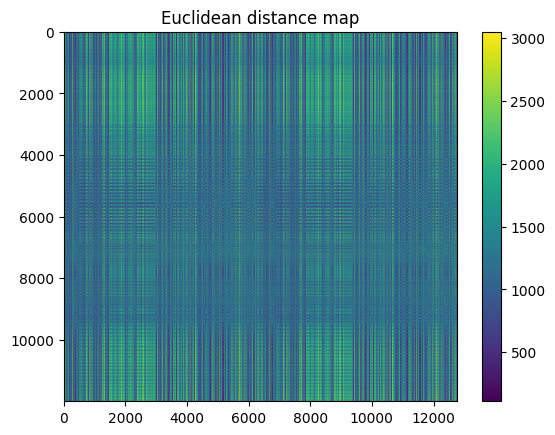

In [8]:
from scipy.optimize import linear_sum_assignment

dp = torch.cdist(targets_embedding, tiles_embedding, p=2)

plt.imshow(dp.cpu()); plt.title("Euclidean distance map"); plt.colorbar()
plt.show()

cost_matrix = dp.detach().cpu().numpy()
cost, rst, _ = lap.lapjv(cost_matrix, extend_cost=True)
rst = rst % SOURCE_N

del cost_matrix
del dp

plot mosaic result

C:\Users\zlak0\AppData\Local\Temp\ipykernel_17924\963961252.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mixed_ab = A[:, :, 1:] * (1 - rate) + B[:, :, 2:] * rate


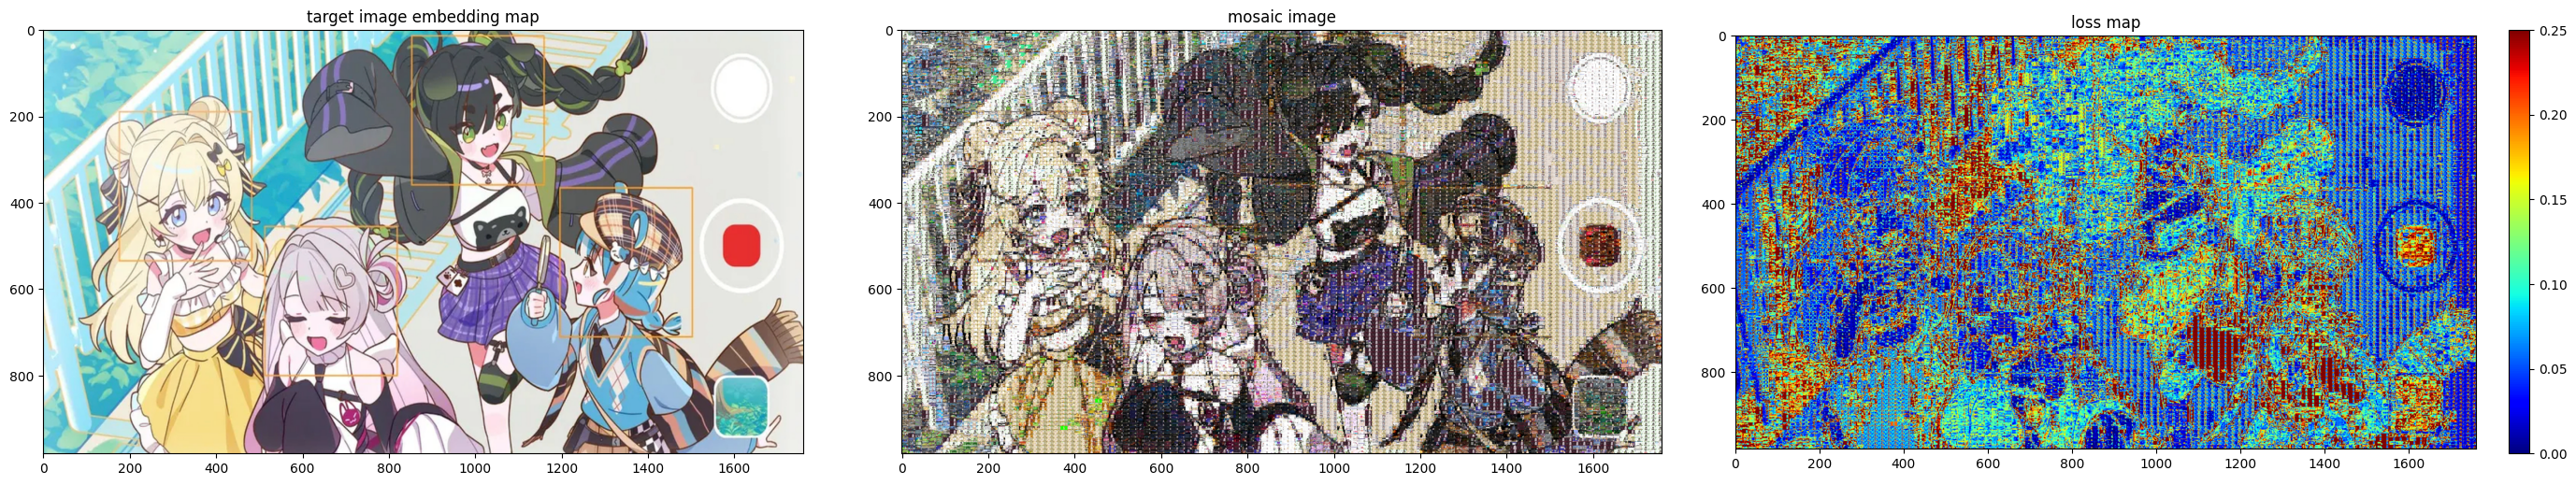

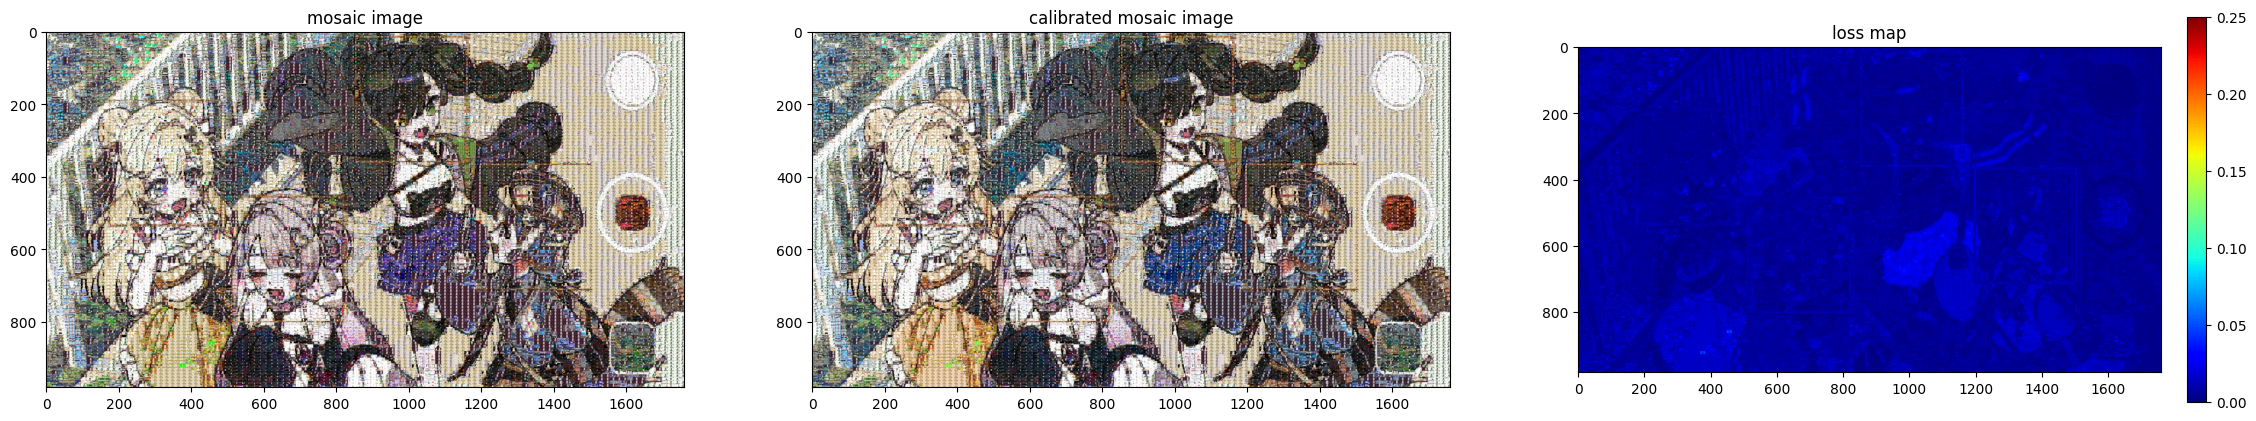

In [9]:
rst_img = torch.zeros(target_embedding_map.shape, dtype=torch.uint8).to(DEVICE)
rst_index = torch.zeros((COL_TILE_N, ROW_TILE_N), dtype=torch.int).to(DEVICE)
rst_metadata = [[None for _ in range(ROW_TILE_N)]for _ in range(COL_TILE_N)]

for i in range(ROW_TILE_N*COL_TILE_N):
    ii, jj = (i//COL_TILE_N), (i%COL_TILE_N)
    r, c = EMBEDDING_ROW * ii, EMBEDDING_COL * jj

    opt_vector = tiles_embedding[rst[i]]
    opt_img = opt_vector.reshape((EMBEDDING_COL, EMBEDDING_ROW, 3)).to(torch.uint8)
    rst_img[c:c+EMBEDDING_COL, r:r+EMBEDDING_ROW, :] = opt_img
    rst_index[jj, ii] = rst[i]
    rst_metadata[jj][ii] = config["label"][rst[i]]

rst_img_blended = blend(rst_img.cpu(), target_embedding_map, BLENDING_RATE).to(dtype=torch.uint8)

plt.figure(figsize=(28, 5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(target_embedding_map, cv2.COLOR_Lab2RGB)); plt.title("target image embedding map")
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(rst_img.cpu().numpy(), cv2.COLOR_Lab2RGB)); plt.title("mosaic image")
loss_map = torch.sqrt(torch.sum((torch.from_numpy(target_embedding_map).to(DEVICE, torch.float32) - rst_img.to(DEVICE, torch.float32))**2, dim=2)) / (255 * np.sqrt(3))
plt.subplot(1, 3, 3); plt.imshow(loss_map.cpu(), cmap='jet', vmin=0, vmax=0.25); plt.title("loss map"); plt.colorbar(fraction=0.046, pad=0.04)
#plt.show()
plt.tight_layout()
plt.savefig('savefig_default.png')

plt.figure(figsize=(28, 5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(rst_img.cpu().numpy(), cv2.COLOR_Lab2RGB)); plt.title("mosaic image")
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(rst_img_blended.cpu().numpy(), cv2.COLOR_Lab2RGB)); plt.title("calibrated mosaic image")
loss_map = torch.sqrt(torch.sum((rst_img.to(DEVICE, torch.float32) - rst_img_blended.to(DEVICE, torch.float32))**2, dim=2)) / (255 * np.sqrt(3))
plt.subplot(1, 3, 3); plt.imshow(loss_map.cpu(), cmap='jet', vmin=0, vmax=0.25); plt.title("loss map"); plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

assemble photographic moasic

In [10]:
rst_mosaic_size = (COL_TILE_N, ROW_TILE_N, SOURCE_SHAPE_HEIGHT, SOURCE_SHAPE_WIDTH, 3)
target_shape = (SOURCE_SHAPE_HEIGHT*COL_TILE_N, SOURCE_SHAPE_WIDTH*ROW_TILE_N, 3)
rst_mosaic = torch.zeros(rst_mosaic_size, dtype=torch.uint8).to(DEVICE)

stride_r, stride_c = int(target_w/ROW_TILE_N), int(target_h/COL_TILE_N)

chunk_size = 1000
with h5py.File(PATH_H5, 'r') as f:
    tiles = f["origin"]
    for p in range(0, SOURCE_N, chunk_size):
      ps, pe = p, min(p+chunk_size, SOURCE_N)
      chunk = f["origin"][ps:pe]

      for i in range(ROW_TILE_N):
          for j in range(COL_TILE_N):
            index = rst_index[j, i]
            if (ps <= index < pe):
              rs, cs = i*stride_r, j*stride_c
              re, ce = rs+stride_r, cs+stride_c

              mask = cv2.resize(img_LAB[cs:ce, rs:re], (SOURCE_SHAPE_WIDTH, SOURCE_SHAPE_HEIGHT))
              rst_mosaic[j, i] = torch.from_numpy(blend(chunk[index-ps], mask, BLENDING_RATE))

              del mask
      del chunk

rst_mosaic = rst_mosaic.permute(0, 2, 1, 3, 4)
rst_mosaic = rst_mosaic.reshape(*target_shape)


# make web viewer
---

make base

In [ ]:

# copy web base
if os.path.exists(OUTPUT_PATH):
    shutil.rmtree(OUTPUT_PATH)
shutil.copytree(WEB_REF_PATH, OUTPUT_PATH, dirs_exist_ok=True)

# save mosaic image
rst_mosaic_RGB = cv2.cvtColor(rst_mosaic.cpu().numpy(), cv2.COLOR_Lab2BGR)
rst_mosaic_path = os.path.join(OUTPUT_PATH, "mosaic.jpg")
cv2.imwrite(rst_mosaic_path, rst_mosaic_RGB)

# save small size\
if(SAVE_AS_JPG):
    for scale in range(2, 5, 1):
        small_size = (int(SOURCE_SHAPE_WIDTH*ROW_TILE_N/scale), int(SOURCE_SHAPE_HEIGHT*COL_TILE_N/scale))
        rst_mosaic_RGB_resized = cv2.resize(rst_mosaic_RGB, small_size)
        rst_mosaic_resized_path = os.path.join(OUTPUT_PATH, f"mosaic_-{scale}.jpg")
        cv2.imwrite(rst_mosaic_resized_path, rst_mosaic_RGB_resized)


In [12]:
del rst_mosaic_RGB
del rst_mosaic
gc.collect()

41079

create tiles

In [ ]:
img_map = Image.open(rst_mosaic_path)
img_width, img_height = img_map.size

mosaic_output_dir = os.path.join(OUTPUT_PATH, "mosaic")
if os.path.exists(mosaic_output_dir):
    import shutil
    shutil.rmtree(mosaic_output_dir)
os.makedirs(mosaic_output_dir)

max_dim = max(img_width, img_height)
max_zoom = math.ceil(math.log(max_dim / WEB_TILE_SIZE, 2)) if WEB_TILE_SIZE < max_dim else 0

for z in range(max_zoom):
    zoom_dir = os.path.join(mosaic_output_dir, str(z))
    os.makedirs(zoom_dir, exist_ok=True)

    scale = 2 ** (max_zoom - z)
    w_z, h_z = math.ceil(img_width / scale), math.ceil(img_height / scale)

    cols = math.ceil(w_z / WEB_TILE_SIZE)
    rows = math.ceil(h_z / WEB_TILE_SIZE)

    for x in range(cols):
        for y in range(rows):
            orig_left = int(x * WEB_TILE_SIZE * scale)
            orig_top = int(y * WEB_TILE_SIZE * scale)
            orig_right = min(int((x + 1) * WEB_TILE_SIZE * scale), img_width)
            orig_bottom = min(int((y + 1) * WEB_TILE_SIZE * scale), img_height)

            image_piece = img_map.crop((orig_left, orig_top, orig_right, orig_bottom))

            t_w = math.ceil((orig_right - orig_left) / scale)
            t_h = math.ceil((orig_bottom - orig_top) / scale)

            if scale != 1:
                image_piece = image_piece.resize((t_w, t_h), Image.Resampling.LANCZOS)

            tile = Image.new("RGB", (WEB_TILE_SIZE, WEB_TILE_SIZE), "black")
            tile.paste(image_piece, (0, 0))

            tile_path = os.path.join(zoom_dir, f"{x}_{y}.jpg")
            tile.save(tile_path, "JPEG", quality=85)

            del image_piece
            del tile

    gc.collect()

img_map.close()
gc.collect()
if (not SAVE_AS_JPG):
    os.remove(rst_mosaic_path)

0

revice web source

In [29]:

# Read metadata
metadata = rst_metadata
grid_cols = 0
grid_rows = 0
metadata_js = json.dumps(metadata)
grid_rows = len(metadata)
if grid_rows > 0:
    grid_cols = len(metadata[0])

# 3. Modify index.html
index_path = os.path.join(OUTPUT_PATH, "index.html")
with open(index_path, "r", encoding="utf-8") as f:
    html_content = f.read()

# Add tooltip style
tooltip_style = """
<style>
.leaflet-tooltip.custom-tooltip {
    background-color: rgba(0, 0, 0, 0.7);
    color: white;
    border: none;
    box-shadow: none;
    padding: 6px 10px;
    font-size: 14px;
    border-radius: 4px;
}
</style>
"""
head_end_marker = '</head>'
html_content = html_content.replace(head_end_marker, tooltip_style + head_end_marker)

# Remove unnecessary CSS
css_to_remove = [
    '<link rel="stylesheet" href="app/easy-button.css" />',
    '<link rel="stylesheet" href="app/help-table.css" />',
    '<link rel="stylesheet" href="app/leaflet-search.css" />'
]
for css in css_to_remove:
    html_content = html_content.replace(css, "")

# Remove unnecessary JS
js_to_remove = [
    '<script src="app/leafletzoom.js"></script>',
    '<script src="app/easy-button.js"></script>',
    '<script src="app/leaflet-search.js"></script>'
]
for js in js_to_remove:
    html_content = html_content.replace(js, "")

new_script = f"""
<script>
var mosaicWidth = {img_width};
var mosaicHeight = {img_height};
var maxZoom = {max_zoom};
var tileSize = {WEB_TILE_SIZE};
var tileMetadata = {metadata_js};
var gridCols = {grid_cols};
var gridRows = {grid_rows};

var map = L.map('AndreaMosaic', {{
    crs: L.CRS.Simple,
    minZoom: 0,
    maxZoom: maxZoom-1
}});

var southWest = map.unproject([0, mosaicHeight], maxZoom);
var northEast = map.unproject([mosaicWidth, 0], maxZoom);
var bounds = new L.LatLngBounds(southWest, northEast);

map.fitBounds(bounds);
map.setMaxBounds(bounds);

L.tileLayer('mosaic/{{z}}/{{x}}_{{y}}.jpg', {{
    minZoom: 0,
    maxZoom: maxZoom-1,
    tileSize: tileSize,
    noWrap: true,
    bounds: bounds,
    tms: true, // Invert y-axis of tiles
    attribution: 'Photographic Mosaic'
}}).addTo(map);

L.control.fullscreen().addTo(map);

var tooltip = L.tooltip({{
    className: 'custom-tooltip',
    permanent: false,
    direction: 'top'
}});

map.on('mousemove', function(e) {{
    if (gridRows === 0 || gridCols === 0) return;

    var point = map.project(e.latlng, maxZoom);

    if (point.x < 0 || point.x > mosaicWidth || point.y < 0 || point.y > mosaicHeight) {{
        tooltip.closeTooltip();
        return;
    }}

    var tileX = Math.floor((point.x / mosaicWidth) * gridCols);
    var tileY = Math.floor((point.y / mosaicHeight) * gridRows);

    if (tileY >= 0 && tileY < tileMetadata.length && tileX >= 0 && tileX < tileMetadata[tileY].length) {{
        var info = tileMetadata[tileY][tileX];
        if (info && info.title) {{
            tooltip.setContent(info.title)
                    .setLatLng(e.latlng)
                    .addTo(map);
        }}
    }} else {{
        tooltip.closeTooltip();
    }}
}});

map.on('mouseout', function(e) {{
    tooltip.closeTooltip();
}});

map.on('dblclick', function(e) {{
    if (gridRows === 0 || gridCols === 0) return;

    var point = map.project(e.latlng, maxZoom);

    if (point.x < 0 || point.x > mosaicWidth || point.y < 0 || point.y > mosaicHeight) {{
        return;
    }}

    var tileX = Math.floor((point.x / mosaicWidth) * gridCols);
    var tileY = Math.floor((point.y / mosaicHeight) * gridRows);

    if (tileY >= 0 && tileY < tileMetadata.length && tileX >= 0 && tileX < tileMetadata[tileY].length) {{
        var info = tileMetadata[tileY][tileX];
        if (info && info.url) {{
            window.open(info.url, '_blank');
        }}
    }}
}});

</script>
"""

script_start_marker = '<script type="application/javascript">'
body_end_marker = '</body>'

start_index = html_content.rfind(script_start_marker)
end_index = html_content.rfind(body_end_marker)

if start_index != -1 and end_index != -1:
    before_script = html_content[:start_index]
    new_html_content = before_script + new_script + body_end_marker

    with open(index_path, "w", encoding="utf-8") as f:
        f.write(new_html_content)
    print(f"Successfully updated {index_path}")
else:
    print("Error: Could not find the script block in index.html to replace.")

Successfully updated hi-blueming-photographic-moaisc\index.html


# Open server
---

In [15]:
if (IS_COLAB):
    import os, threading, contextlib, sys
    from http.server import HTTPServer, SimpleHTTPRequestHandler

    PORT = 8001

    class TargetedHandler(SimpleHTTPRequestHandler):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, directory=OUTPUT_PATH, **kwargs)
        def log_message(self, format, *args): pass

    def run_server():
        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stderr(devnull):
                try:
                    HTTPServer.allow_reuse_address = True
                    server = HTTPServer(('0.0.0.0', PORT), TargetedHandler)
                    server.serve_forever()
                except:
                    pass

    threading.Thread(target=run_server, daemon=True).start()

    output.clear()
    output.serve_kernel_port_as_window(PORT)

In [16]:
et = time.time()
d = et-st

print(f"""
tile size\t: {SOURCE_SHAPE_WIDTH} x {SOURCE_SHAPE_HEIGHT} px
embedding size\t: {EMBEDDING_ROW} x {EMBEDDING_COL} px ({EMBEDDING_LENGTH} axis)
mosaic size\t: {ROW_TILE_N} x {COL_TILE_N} tile

duration\t: {int(d//60)} min {int(d%60)} sec
""")


tile size	: 426 x 240 px
embedding size	: 16 x 9 px (432 axis)
mosaic size	: 110 x 109 tile

duration	: 7 min 46 sec



# Download
---

In [17]:
raise Exception("소코마데다")

Exception: 소코마데다

In [ ]:
# <- 이거 클릭
# 3분 소요

download(OUTPUT_PATH, output="hi-blueming-photographic-moaisc")